使用简单GAN模拟蝙蝠
===

# 1.简单模型

In [4]:
import skimage.io as si
import torch
import sys
sys.path.append('../')
import JLib.utils as utils
import jjzhk.imageutils  as iu
import jjzhk.progressbar as bar

class SimpleMLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.map1 = torch.nn.Linear(input_size, hidden_size)
        self.map2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.LeakyReLU(negative_slope = 0.1)(self.map1(x))
        return torch.nn.functional.sigmoid(self.map2(x))

# 2.全局设置

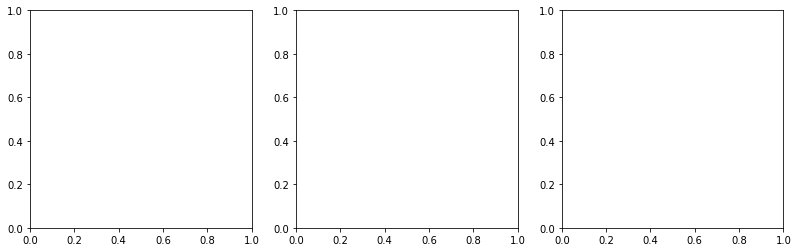

In [9]:
z_dim = 2
DIMENSION = 2
iterations = 3000
bs = 2000

INPUT_IMAGE_PATH = "inputs/batman.jpg"
density_img = si.imread(INPUT_IMAGE_PATH, True)
lut_2d = utils.generate_lut(density_img)

visualizer = utils.GANDemoVisualizer('GAN 2D Example Visualization of {}'.format(INPUT_IMAGE_PATH))
generator = SimpleMLP(input_size=z_dim, hidden_size=50, output_size=DIMENSION)
discriminator = SimpleMLP(input_size=DIMENSION, hidden_size=100, output_size=1)

if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()

criterion = torch.nn.BCELoss()
d_optimizer = torch.optim.Adadelta(discriminator.parameters(), lr=1)
g_optimizer = torch.optim.Adadelta(generator.parameters(), lr=1)

# 3.训练

In [7]:
proBar = bar.ProgressBar(1, iterations, "D Loss:(real/fake) %.3f/%.3f,G Loss:%.3f")

for train_iter in range(1, iterations + 1):
    for d_index in range(3):
        # 1. Train D on real+fake
        discriminator.zero_grad()

        #  1A: Train D on real
        real_samples = utils.sample_2d(lut_2d, bs)
        d_real_data = torch.autograd.Variable(torch.Tensor(real_samples))
        if torch.cuda.is_available() > 0:
            d_real_data = d_real_data.cuda()
        d_real_decision = discriminator(d_real_data)
        labels = torch.autograd.Variable(torch.ones(bs))
        if torch.cuda.is_available() > 0:
            labels = labels.cuda()
        d_real_loss = criterion(d_real_decision, labels)  # ones = true

        #  1B: Train D on fake
        latent_samples = torch.randn(bs, z_dim)
        d_gen_input = torch.autograd.Variable(latent_samples)
        if torch.cuda.is_available() > 0:
            d_gen_input = d_gen_input.cuda()
        d_fake_data = generator(d_gen_input).detach()  # detach to avoid training G on these labels
        d_fake_decision = discriminator(d_fake_data)
        labels = torch.autograd.Variable(torch.zeros(bs))
        if torch.cuda.is_available() > 0:
            labels = labels.cuda()
        d_fake_loss = criterion(d_fake_decision, labels)  # zeros = fake

        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()

        d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

    for g_index in range(1):
        # 2. Train G on D's response (but DO NOT train D on these labels)
        generator.zero_grad()

        latent_samples = torch.randn(bs, z_dim)
        g_gen_input = torch.autograd.Variable(latent_samples)
        if torch.cuda.is_available() > 0:
            g_gen_input = g_gen_input.cuda()
        g_fake_data = generator(g_gen_input)
        g_fake_decision = discriminator(g_fake_data)
        labels = torch.autograd.Variable(torch.ones(bs))
        if torch.cuda.is_available() > 0:
            labels = labels.cuda()
        g_loss = criterion(g_fake_decision, labels)  # we want to fool, so pretend it's all genuine

        g_loss.backward()
        g_optimizer.step()  # Only optimizes G's parameters

    loss_d_real = d_real_loss.item()
    loss_d_fake = d_fake_loss.item()
    loss_g = g_loss.item()

    proBar.show(1, loss_d_real, loss_d_fake, loss_g)
    if train_iter == 1 or train_iter % 100 == 0:
        msg = 'Iteration {}: D_loss(real/fake): {:.6g}/{:.6g} G_loss: {:.6g}'.format(train_iter, loss_d_real, loss_d_fake, loss_g)

        gen_samples = g_fake_data.data.cpu().numpy()

        visualizer.draw(real_samples, gen_samples, msg, show=False)
        visualizer.savefig('outputs/Pytorch_Batman_%04d' % train_iter)


Epoch:1 / 1 [                                                                                                    ] 1 / 3000 ,D Loss:(real/fake) 0.684/0.705,G Loss:0.685,remain=0:32:23

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch:1 / 1 [****************************************************************************************************] 3000 / 3000 ,D Loss:(real/fake) 0.692/0.694,G Loss:0.692,total=0:09:000


# 4.生成gif

In [8]:
maker = iu.ImageToGif()
maker("outputs")

![images](images/batman.gif)